In [1]:
import sys
sys.path.append('/home/lumargot/trachoma/src/py')

import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # put -1 to not use any

In [2]:
import os
import pandas as pd
import numpy as np 
import SimpleITK as sitk
import torch
import cv2

from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

In [ ]:
df_train = pd.read_csv('/CMF/data/lumargot/trachoma/mtss_seg_train_train.csv')

df_patches_train = pd.read_csv('/CMF/data/lumargot/trachoma/csv_mtss_pret/csv_updated/mtss_pret_combined.csv')

In [5]:
df_patches_train_popp = df_patches_train.loc[df_patches_train['dataset'] == 'PoPP_Data']

In [20]:
concat_labels=['overcorrection', 'ECA', 'Gap', 'Fleshy']
drop_labels = ['Short Incision', 'Reject']

df_patches_train_popp = remove_labels(df_patches_train_popp, 'class', 'label', drop_labels=drop_labels, concat_labels=concat_labels)

In [28]:
subjects = df_patches_train_popp['filename'].unique()

In [51]:
df_patches_train_popp

,index,Unnamed: 0.1,Unnamed: 0,cid,x_patch,y_patch,label,filename,dataset,class,to_drop
0,9103,9113,9113,11010,1114,2426,Healthy,PoPP_Data/mtss/img/11010_12Intra_os_postop.jpg,PoPP_Data,1,0
1,9104,9115,9115,11010,1141,2381,Healthy,PoPP_Data/mtss/img/11010_12Intra_os_postop.jpg,PoPP_Data,1,0
2,9105,9117,9117,11010,1206,2322,Healthy,PoPP_Data/mtss/img/11010_12Intra_os_postop.jpg,PoPP_Data,1,0
3,9106,9119,9119,11010,1287,2264,Healthy,PoPP_Data/mtss/img/11010_12Intra_os_postop.jpg,PoPP_Data,1,0
4,9107,9121,9121,11010,1380,2217,Healthy,PoPP_Data/mtss/img/11010_12Intra_os_postop.jpg,PoPP_Data,1,0
...,...,...,...,...,...,...,...,...,...,...,...
18442,27545,46045,46045,14047,1760,1979,Entropion,PoPP_Data/mtss/img/14047_12Intra_od_postop.jpg,PoPP_Data,2,0
18443,27546,46047,46047,14047,1838,2016,Entropion,PoPP_Data/mtss/img/14047_12Intra_od_postop.jpg,PoPP_Data,2,0
18444,27547,46049,46049,14047,1917,2058,Entropion,PoPP_Data/mtss/img/14047_12Intra_od_postop.jpg,PoPP_Data,2,0
18445,27548,46051,46051,14047,1991,2100,Entropion,PoPP_Data/mtss/img/14047_12Intra_od_postop.jpg,PoPP_Data,2,0


In [29]:
def gt_eye_outcome(targets_labels):
  unique_labels = np.unique(targets_labels, return_counts=False)
  if len(unique_labels) == 2:
    if 1 in unique_labels:
      outcome = max(unique_labels)
    else: #conflict
      outcome = -1 
      print(targets_labels.to_list())
  elif len(unique_labels) == 3: #conflict 
    outcome = -1
    print(targets_labels.to_list())
  else:
    outcome = unique_labels[0]
  
  return outcome

def remove_labels(df, class_column, label_column, drop_labels=None, concat_labels=None):
  df = df.loc[df['to_drop'] == 0]
  if drop_labels is not None:
      df = df[ ~ df[label_column].isin(drop_labels)]

  if concat_labels is not None:
      replacement_val = df.loc[ df[label_column] == concat_labels[0]][class_column].unique()
      df.loc[ df[label_column].isin(concat_labels), class_column ] = replacement_val[0]

  unique_classes = sorted(df[class_column].unique())
  class_mapping = {value: idx+1 for idx, value in enumerate(unique_classes)}

  df[class_column] = df[class_column].map(class_mapping)
  return df.reset_index()


In [38]:
# l_outcome = []
# for sub in subjects:
#   df_sub = df_patches_train_popp.loc[df_patches_train_popp['filename']==sub]
#   outcome = gt_eye_outcome(df_sub['class'])
#   if outcome ==-1:
#     print(sub)
#     print()
#   l_outcome.append(outcome)

In [62]:
df_train = pd.read_csv('/CMF/data/lumargot/trachoma/mtss_seg_test.csv')

In [52]:
df_outcomes = pd.read_csv('outcomes_popp_eye_level_method.csv')

In [63]:
l_subject_outcome = []
for idx, row in df_train.iterrows():
  outcomes = df_outcomes.loc[df_outcomes['subject'] == row['img']]
  if len(outcomes) == 1:
    l_subject_outcome.append(outcomes['eye_outcome'].item())
  else:
    l_subject_outcome.append(int(row['class']))

In [64]:
df_train['new_label'] = l_subject_outcome

In [65]:
df_train.to_csv('/CMF/data/lumargot/trachoma/mtss_seg_test.csv')

In [ ]:
def compute_eye_bbx(seg, label=1, pad=0):

    shape = seg.shape
    
    ij = torch.argwhere(seg.squeeze() != 0)

    bb = torch.tensor([0, 0, 0, 0])# xmin, ymin, xmax, ymax

    bb[0] = torch.clip(torch.min(ij[:,1]) - shape[1]*pad, 0, shape[1])
    bb[1] = torch.clip(torch.min(ij[:,0]) - shape[0]*pad, 0, shape[0])
    bb[2] = torch.clip(torch.max(ij[:,1]) + shape[1]*pad, 0, shape[1])
    bb[3] = torch.clip(torch.max(ij[:,0]) + shape[0]*pad, 0, shape[0])
    
    return bb

In [ ]:
img_path = '/CMF/data/lumargot/trachoma/PoPP_Data/mtss/img/11408_12Intra_os_postop.jpg'
seg_path = img_path.replace('img', 'seg').replace('.jpg', '.nrrd')

seg = torch.tensor(np.squeeze(sitk.GetArrayFromImage(sitk.ReadImage(seg_path)).copy())).to(torch.float32)
img = torch.tensor(np.squeeze(sitk.GetArrayFromImage(sitk.ReadImage(img_path)).copy())).to(torch.float32)
# img = img.permute((2, 0, 1))
img = img/255.0

## crop img within segmentation
bbx_eye = compute_eye_bbx(seg, pad=0.05)
img_cropped = img[bbx_eye[1]:bbx_eye[3],bbx_eye[0]:bbx_eye[2] ,:]
seg_cropped = seg[bbx_eye[1]:bbx_eye[3],bbx_eye[0]:bbx_eye[2] ]
seg_cropped[ seg_cropped!=3 ] =0
h,w = seg_cropped.shape


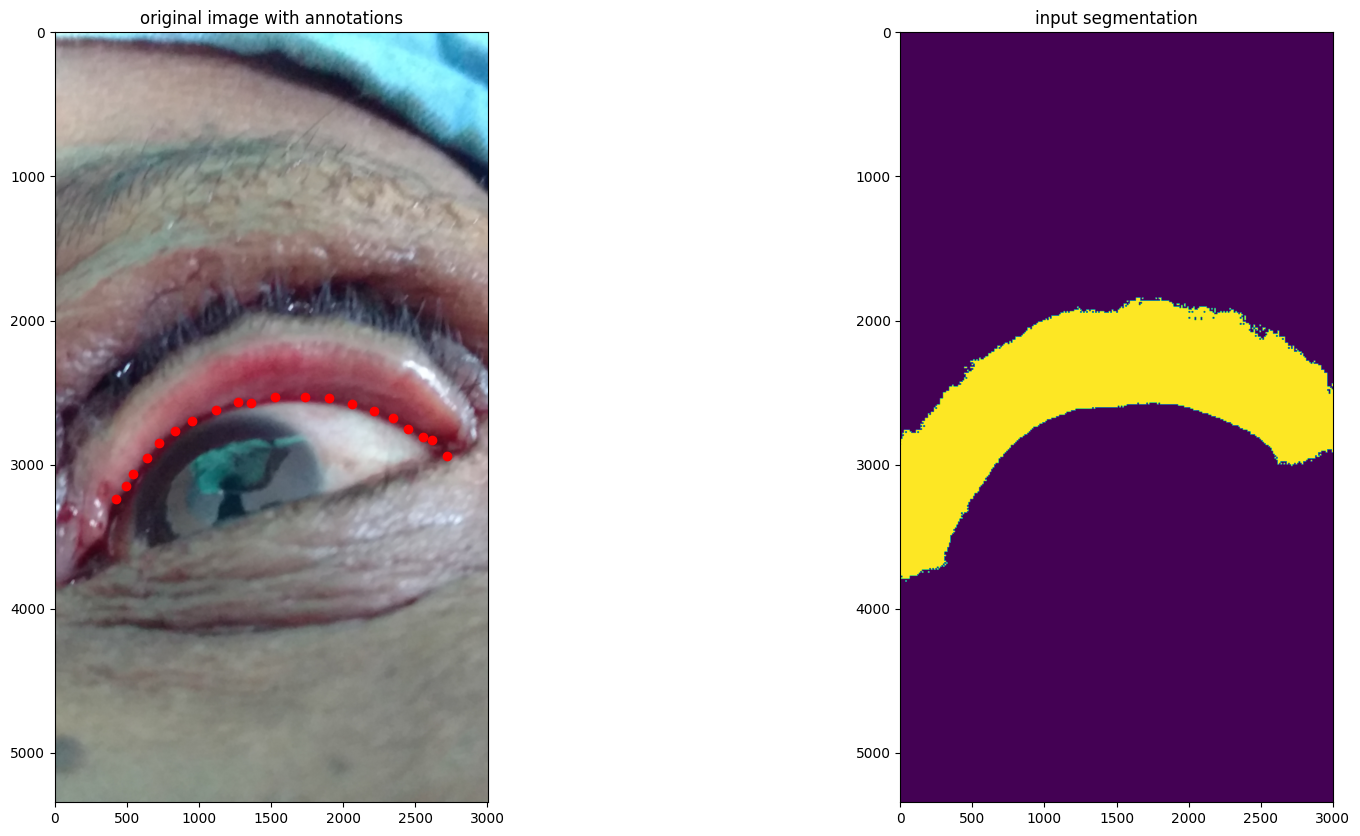

In [64]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(img)
df = df.sort_values(by='x')
plt.plot(df['x'], df['y'], 'or')
plt.title('original image with annotations')

plt.subplot(122)
plt.imshow(seg)
plt.title('input segmentation')

plt.savefig('input_data.png', dpi=200)

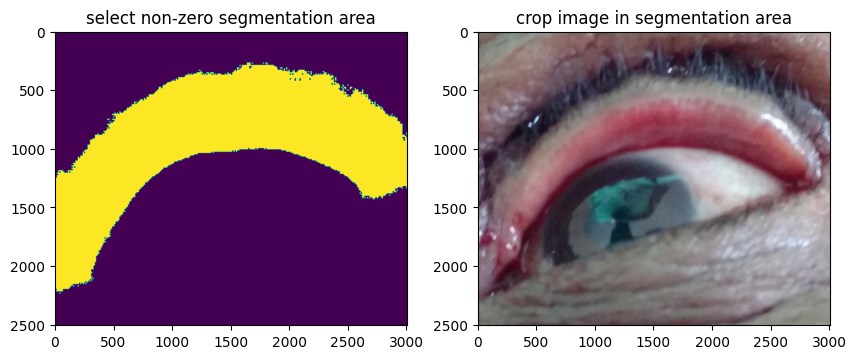

In [23]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(seg_cropped)
plt.title('select non-zero segmentation area')

plt.subplot(122)
plt.imshow(img_cropped)
plt.title('crop image in segmentation area')

plt.savefig('segmented_data.png', dpi=200)

In [60]:
pad = int(img_cropped.shape[1]/10)
classes, bbx  = [], []
df = pd.read_csv('/CMF/data/lumargot/trachoma/PoPP_Data/mtss/old_patches/11408_12Intra_os_postop.csv')
if not df.empty:
    for k, row in df.iterrows():

        if row['label'] == 'Healthy':
            class_idx =  torch.tensor(1).to(torch.long)
        elif row['label'] == 'Entropion':
            class_idx =  torch.tensor(2).to(torch.long)

        else :
            class_idx =  torch.tensor(3).to(torch.long)

        x, y = row['x'], row['y']

        cropped_x, cropped_y = x - bbx_eye[0], y -bbx_eye[1]
        box = torch.tensor([max((cropped_x-2*pad/3), 0),
                            max((cropped_y-5*pad/3), 0),
                            min((cropped_x+2*pad/3), img_cropped.shape[1]),
                            min((cropped_y+pad/3), img_cropped.shape[0])])

        classes.append(class_idx)
        bbx.append(box)

else:
    classes.append(torch.tensor(1).to(torch.long))
    bbx.append(torch.tensor([5,5,img_cropped.shape[2]-5, img_cropped.shape[1]-5]))
    bbx, classes = torch.cat(bbx), torch.cat(classes)

x_cropped = df['x'] - bbx_eye[0].numpy()
y_cropped = df['y'] - bbx_eye[1].numpy()


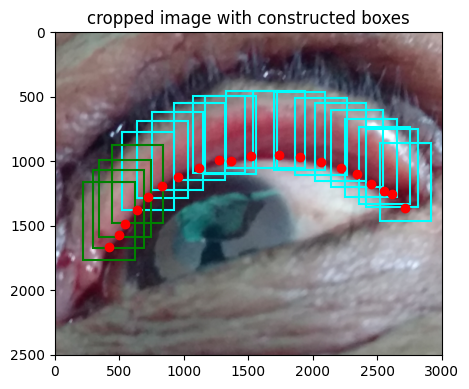

In [65]:
plt.figure(figsize=(5,5))
# plt.subplot(121)
# plt.imshow(img)


# plt.subplot(122)
ax = plt.gca()
ax.imshow(img_cropped)
ax.set_title('cropped image with constructed boxes')
ax.plot(x_cropped, y_cropped, 'or')


for j in range(len(bbx)):
  box = bbx[j]
  label = classes[j]

  x1, y1, x2, y2 = box
  width, height = x2 - x1, y2 - y1
  color = 'cyan'
  if label == 1:
    color = 'green'
  elif label == 2:
    color ='blue'

  rect = Rectangle((x1, y1), width, height, fill=False, color=color, linewidth=1.5)
  ax.add_patch(rect)

plt.savefig('annotations_and_boxes.png', dpi=200)